In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers

     |████████████████████████████████| 5.3 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 46.3 MB/s 
     |████████████████████████████████| 163 kB 68.7 MB/s 


In [ ]:
# import relevant information
import re
import random
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
from transformers import BertTokenizer, TFBertModel

In [ ]:
# check to see if GPU available and set the data path
print('GPU name: ', tf.config.list_physical_devices('GPU'))
DATA_DIR = "/content/drive/MyDrive/W266 Project/w266-finalproj/data"

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# importing BERT models; we'll be using BERT base case for this experiment
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# load the data 
# from a sample of 6000 pop lyrics, let's use 2000 for fine tuning task
# the rest will be use for training a decoder layer
pop_data = pd.read_csv(f"{DATA_DIR}/02_intermediate/pop_sample.csv")
pop_data = pop_data.loc[:, ~pop_data.columns.str.contains('^Unnamed')]

# sampling data without replacement so the datasets do not mixed together
fine_tuning_set = pop_data.sample(n=2000, replace=False)
generation_set = pop_data.drop(fine_tuning_set.index)

In [ ]:
fine_tuning_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2650 to 3425
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artist    2000 non-null   object
 1   genre     2000 non-null   object
 2   title     2000 non-null   object
 3   lyrics    2000 non-null   object
 4   word_num  2000 non-null   int64 
 5   language  2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 109.4+ KB


In [ ]:
generation_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 1 to 5998
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artist    4000 non-null   object
 1   genre     4000 non-null   object
 2   title     4000 non-null   object
 3   lyrics    4000 non-null   object
 4   word_num  4000 non-null   int64 
 5   language  4000 non-null   object
dtypes: int64(1), object(5)
memory usage: 218.8+ KB


## Data Preprocessing
A quick look at the lyrics, the data is a little dirty. We will need to do some preprocessing before it is ready to use. The following pre-processing procedures will be apply:
1. removal of odds tokens (ie: \n)
2. tokenization

In [ ]:
# training data processing
stopChars = [',','(',')','.','-','[',']','"']

# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

# tokenization 
def corpusToList(corpus):
    corpusList = [w for w in corpus.split(' ')] 
    corpusList = [i for i in corpusList if i] #removing empty strings from list
    return corpusList

def sample_data(genre, sample_size):
    random.seed(69)
    data1 = data.copy()
    data1 = data1[data1['genre'] == genre].sample(sample_size)
    data1['lyrics'] = data1['lyrics'].astype(str)
    data1['lyrics']= data1['lyrics'].apply(preprocessText)
    return data1

def tokenize_data(data):
    data = data.copy()
    word_list = []
    for i, row in data.iterrows():
        lyric = row['lyrics']
        lyric = lyric.replace('\n', ' ')
        lyric = lyric.replace('\t', ' ')
        lyric = lyric.replace('!', ' ! ')
        lyric = lyric.replace('?', ' ? ')
        lyric = lyric.replace('#', ' ')
        lyric = re.findall(r'\S+|\n', lyric)
        word_list.append(lyric)
    # concatenating the word list to create a corpus
    DP_text = [j for i in word_list for j in i]
    print('corpus length:', len(DP_text))
    return(DP_text)

# Create a dictionary of characters, see the index of characters.
def dictionary_maker(words):
    char_to_int = dict((c, i) for i, c in enumerate(words))
    int_to_char = dict((i, c) for i, c in enumerate(words))
    return(char_to_int, int_to_char)


def make_sentences_and_next_chars(seq_length, DP_text, step):
    sentences = []
    next_chars = []

    # Create Target and sentences window
    for i in range(0, len(DP_text) - seq_length, step):
        # range from current index to sequence length charaters
        sentences.append(DP_text[i: i + seq_length])  
        next_chars.append(DP_text[i + seq_length]) # the next character
    
    sentences = np.array(sentences)
    next_chars = np.array(next_chars)
    return(sentences, next_chars)

In [ ]:
# Define Hard Code Max Sequence Length
MAX_SEQUENCE_LENGTH = 16

In [ ]:
DP_pop = tokenize_data(generation_set)
pop_words = sorted(list(set(DP_pop)))
pop_char_to_int, pop_int_to_char = dictionary_maker(pop_words)
pop_sentences, pop_next_chars = make_sentences_and_next_chars(MAX_SEQUENCE_LENGTH, DP_pop, 1)

corpus length: 2297529


In [ ]:
def getdata_raw(sentences, next_chars, seq_length, char_to_int):
    """
        Create a sequence of n character as features X
        Use next character as target y
        TODO: clean this up
    """
    X = []
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        x_temp = []
        for t, char in enumerate(sentence):
            x_temp.append(char)
        x_temp = " ".join(x_temp)
        X.append(x_temp)
        y[i] = char_to_int[next_chars[i]]
    # X_total = " ".join(X)
    return X, y

# create train faetures and word output
x_train, y_train = getdata_raw(pop_sentences, pop_next_chars, MAX_SEQUENCE_LENGTH, pop_char_to_int)

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(x_train, truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
# valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
# test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

In [ ]:
# Let's try BERT :D
def build_bert_model(checkpoint = model_checkpoint,
                                hidden_size = 201, 
                                dropout=0.3,
                                learning_rate=0.01):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    ### YOUR CODE HERE

    # # Freeze all layers of pre-trained BERT model
    # bert_model.trainable = False

    # Compile BERT inputs
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    # get the CLS token to be feed into the classification layer
    pooled_token = bert_out[1]
    # cls_token = bert_out[0][:, 0, :]

    # create the hiden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    # creating a softmax layer to be able to output a probability distribution for available target name
    classification = tf.keras.layers.Dense(len(pop_words), activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    # compile the model with sparse_categorical_crossentropy for multiclass classification
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss="sparse_categorical_crossentropy", 
                                 metrics="accuracy")

    ### END YOUR CODE
    return classification_model


In [ ]:
bert_model = build_bert_model(checkpoint = model_checkpoint)
bert_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 16)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 16)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 16)]        0           []                               
 er)                                                                                              
                                                                                              

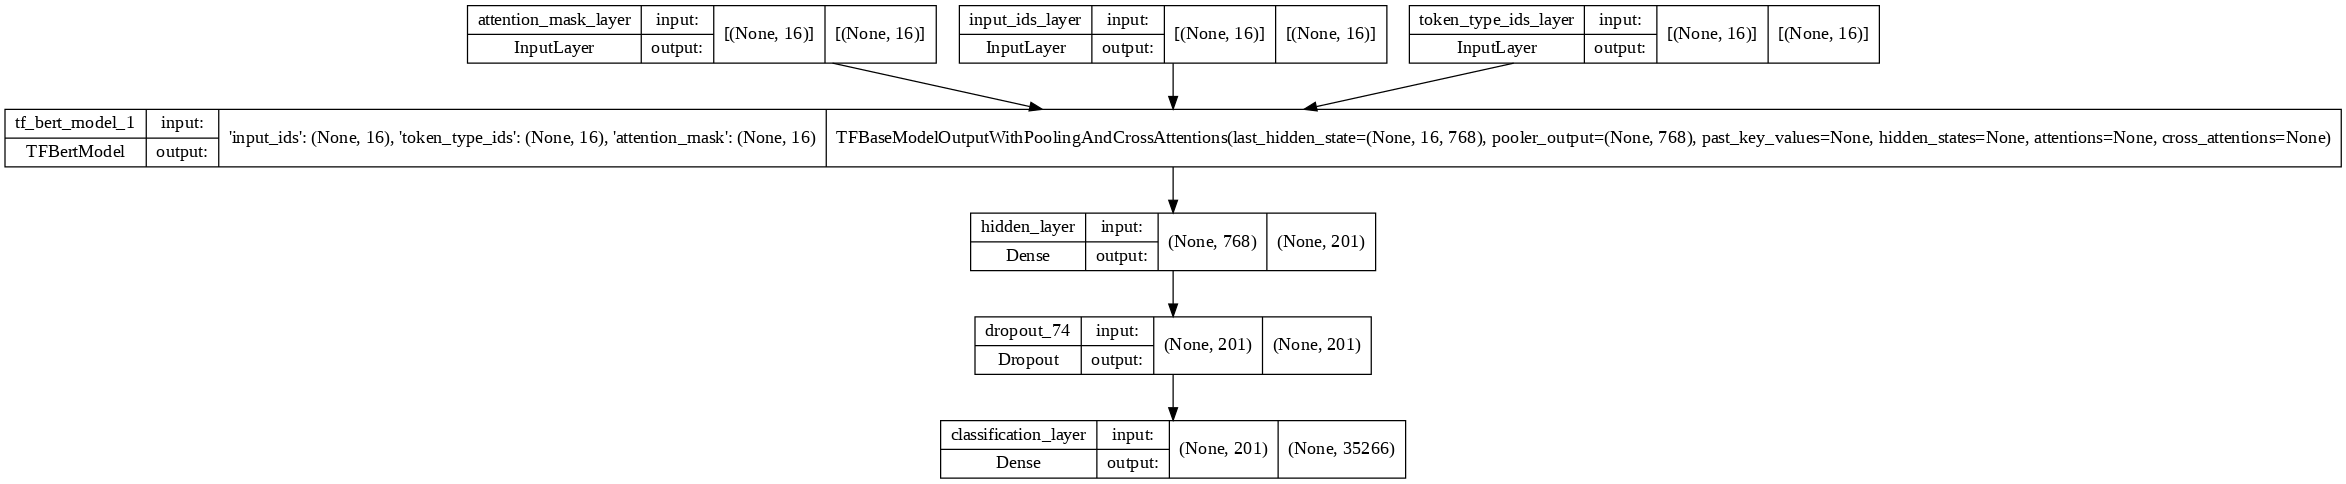

In [ ]:
keras.utils.plot_model(bert_model, show_shapes=True, dpi=90)

In [ ]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
bert_model_history = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  y_train,   
                                                  validation_split=0.1,
                                                  batch_size=128, 
                                                  epochs=3)  

Epoch 1/3
16155/16155 [==============================] - 1319s 81ms/step - loss: 6.5129 - accuracy: 0.0422 - val_loss: 6.5281 - val_accuracy: 0.0430
Epoch 2/3
16155/16155 [==============================] - 1296s 80ms/step - loss: 6.4616 - accuracy: 0.0423 - val_loss: 6.5351 - val_accuracy: 0.0430
Epoch 3/3
16155/16155 [==============================] - 1302s 81ms/step - loss: 6.4611 - accuracy: 0.0423 - val_loss: 6.5354 - val_accuracy: 0.0430


In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    predictions = np.argmax(preds, axis=-1)
    return predictions[0]

In [ ]:
seq_length = 16
char_to_int = pop_char_to_int
int_to_char = pop_int_to_char
sentence = ["the", "change", "in", "season", "##", 
            "colors", "what", "was", "lost", "##"
            "creating", "a", "moment", "##",
            "for", "ourselves"]

variance = .5
generated = []
original = sentence
window = sentence

for i in tqdm(range(100)):
    x = []
    for t, char in enumerate(window):
      x.append(char)

    x = " ".join(x)
    
    # bert something something....
    x_input = bert_tokenizer(x, truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
    pred = bert_model([x_input.input_ids, x_input.token_type_ids, x_input.attention_mask])
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char
    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict

print(" ".join(original + generated))
    

  0%|          | 0/100 [00:00<?, ?it/s]

the change in season colors what was lost creating a moment for ourselves together Preserving only you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you
